In [1]:
import json
# Reading the lstm_evaluation_metrics_file
root_path = "/Users/ybatash/Workspace/tau.ac.il/tau-final-project/data/trained_models"

def read_evaluation_metrics_files(files_list):
    evaluation_metrics = []
    for file in files_list:   
        try:
            with open(file, 'r') as json_file:
                evaluation_metrics.append(json.load(json_file))
        #     print("\nData read back from file:")
        #     print(loaded_data)
        except IOError as e:
            print(f"Error reading from file {file}: {e}")
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from file {file}: {e}")
    return evaluation_metrics          


In [2]:
lstm_evaluation_metrics_files = [
    f"{root_path}/1_min/13_09_2025_23_50/lstm_evaluation_metrics.json",
    f"{root_path}/5_min/14_09_2025_00_05/lstm_evaluation_metrics.json",
    f"{root_path}/15_min/14_09_2025_00_17/lstm_evaluation_metrics.json"    
]

passive_evaluation_metrics_files = [
    f"{root_path}/1_min/13_09_2025_23_50/passive_evaluation_metrics.json",
    f"{root_path}/5_min/14_09_2025_00_05/passive_evaluation_metrics.json",
    f"{root_path}/15_min/14_09_2025_00_17/passive_evaluation_metrics.json"
]

lstm_evaluation_metrics = read_evaluation_metrics_files(files_list=lstm_evaluation_metrics_files)
passive_evaluation_metrics = read_evaluation_metrics_files(files_list=passive_evaluation_metrics_files)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def cast_value_to_numric(val):
    # Clean up some string values for numerical comparison
    if isinstance(val, str):
        if '%' in val:
            val = float(val.replace('%', '').replace(',', ''))
        elif '$' in val:
            val = float(val.replace('$', '').replace(',', ''))
        elif 'seconds' in val:
            val = float(val.replace(' seconds', ''))
        elif 'ms/prediction' in val:
            val = float(val.replace(' ms/prediction', ''))
        elif ',' in val:
            val = float(val.replace(',', ''))
        else:
            try:
                val = float(val) # Try converting other numbers
            except ValueError:
                pass # Keep as string if it can't be converted
    return val


def json_to_flat_df(eval_jsons):
    # Convert the list of dictionaries into a flattened DataFrame for easier analysis
    # We need to flatten the nested dictionaries first
    flattened_data = []
    for entry in eval_jsons:
        flat_entry = {'Data_Resolution': entry['Data_Resolution']}      
        for category, metrics in entry.items():
            if 'Data_Resolution' not in category:
                if isinstance(metrics, dict):
                    for metric_name, value in metrics.items():
                        flat_entry[f'{category}_{metric_name.replace(" ", "_")}'] = cast_value_to_numric(value)
                else:
                    flat_entry[category] = cast_value_to_numric(metrics)                
        flattened_data.append(flat_entry)
    
    return pd.DataFrame(flattened_data)

# Set 'Data Resolution' as index for easier lookup if preferred, or keep as column
lstm_df = json_to_flat_df(lstm_evaluation_metrics)
passive_df = json_to_flat_df(passive_evaluation_metrics).add_prefix("Passive_")

df = lstm_df.join(passive_df)
df["LSTM_Passive_Cumulative_Return_Diff"] = df["Trading_Simulation_Cumulative_Return"] - df["Passive_Cumulative_Return"]
df["LSTM_Passive_Cumulative_Return_Ratio"] = df["Trading_Simulation_Cumulative_Return"]/df["Passive_Cumulative_Return"]

# display(df.T)


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define font sizes for easy customization
TITLE_FONT_SIZE = 22
LABEL_FONT_SIZE = 22
TICK_FONT_SIZE = 22
LEGEND_FONT_SIZE = 22
ANNOTATION_FONT_SIZE = 22
FIGSIZE = (18, 10)

def plot_3_axes_graph(PALETTE,
                      bars_coulmns,
                      X,
                      Y,
                      Y2,
                      combined_legend_label,
                      color_,
                      title_,
                      y2_lim_,
                      y1_metric_suffix,
                      y2_metric_suffix,
                      plot_legend_loc,
                      rename_columns,
                      label_offset=2
):
    # Melt the DataFrame for the bar plot
    melted_plot_df = df.reset_index().melt(
        id_vars=X,
        value_vars=bars_coulmns,
        var_name='Metric',
        value_name=Y
    )
    
    if rename_columns is not None:
        melted_plot_df = melted_plot_df.replace(rename_columns)   

    # --- Create the Plot ---
    fig, ax = plt.subplots(figsize=FIGSIZE) # Use fig, ax for more control

    # Plot 1: Bar plot for MAE and RMSE on the primary axis (ax)
    sns.barplot(
        x=X,
        y=Y,
        hue='Metric',
        data=melted_plot_df,
        palette=PALETTE,
        ax=ax # Specify the axis to draw on
    )


    # Add annotations to the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}{y1_metric_suffix}', # Format to 3 decimal places
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=ANNOTATION_FONT_SIZE,
                    xytext=(0, 10),
                    textcoords='offset points')

    if Y2 is not None:
        # Plot 2: Line plot for Directional Accuracy on the secondary axis (ax2)
        ax2 = ax.twinx()
        sns.lineplot(
            x=X,
            y=Y2,
            data=df,
            marker='s',
            markersize=10, # Make marker bigger
            label=combined_legend_label, # This label will be used for the combined legend
            ax=ax2,
            color=color_,
            linestyle='--'
        )

        # Add annotations to the line plot points
        for i, val in enumerate(df[Y2]):
            ax2.text(i, val + label_offset, f"{val:.2f}{y2_metric_suffix}", # Add '%' and format
                     ha='center', color=color_, fontsize=ANNOTATION_FONT_SIZE)
            
        ax2.set_ylabel(combined_legend_label, fontsize=LABEL_FONT_SIZE, color=color_)
        ax2.tick_params(axis='y', labelcolor=color_, labelsize=TICK_FONT_SIZE)        
        ax2.set_ylim(y2_lim_)
        handles2, labels2 = ax2.get_legend_handles_labels()
        ax2.get_legend().remove()
    else:
        handles2=[]
        labels2=[]

    # --- Styling and Font Sizes ---
    ax.set_title(title_, fontsize=TITLE_FONT_SIZE, pad=20)
    ax.set_xlabel(X.replace("_"," "), fontsize=LABEL_FONT_SIZE)
    ax.set_ylabel(Y, fontsize=LABEL_FONT_SIZE)
#     ax2.set_ylabel(combined_legend_label, fontsize=LABEL_FONT_SIZE, color=color_)

    # Set tick font sizes
    ax.tick_params(axis='x', labelsize=TICK_FONT_SIZE, rotation=0) # Keep x-axis labels horizontal
    ax.tick_params(axis='y', labelsize=TICK_FONT_SIZE)
#     ax2.tick_params(axis='y', labelcolor=color_, labelsize=TICK_FONT_SIZE)

    # Set y-axis limits
    ax.set_ylim(0, max(melted_plot_df[Y]) * 1.2) # Give some space for bar annotations
#     ax2.set_ylim(y2_lim_)
    ax.grid(axis='y', linestyle=':', alpha=0.7)

    # --- Combine Legends into One ---
    # 1. Get handles and labels from both axes
    handles1, labels1 = ax.get_legend_handles_labels()
#     handles2, labels2 = ax2.get_legend_handles_labels()

    # 2. Remove the individual, automatically generated legends
    ax.get_legend().remove()
#     ax2.get_legend().remove()

    # 3. Create a single, combined legend on the main axis
    ax.legend(
        handles=handles1 + handles2,
        labels=labels1 + labels2,
        title='Metric',
        fontsize=LEGEND_FONT_SIZE,
        title_fontsize=LEGEND_FONT_SIZE + 2, # Make legend title slightly bigger
        loc=plot_legend_loc
    )

    # Ensure the plot layout is tight and clean
    fig.tight_layout()
    plt.show()

    print("\n")

# Model Accuracy Metrics Across Data Resolutions

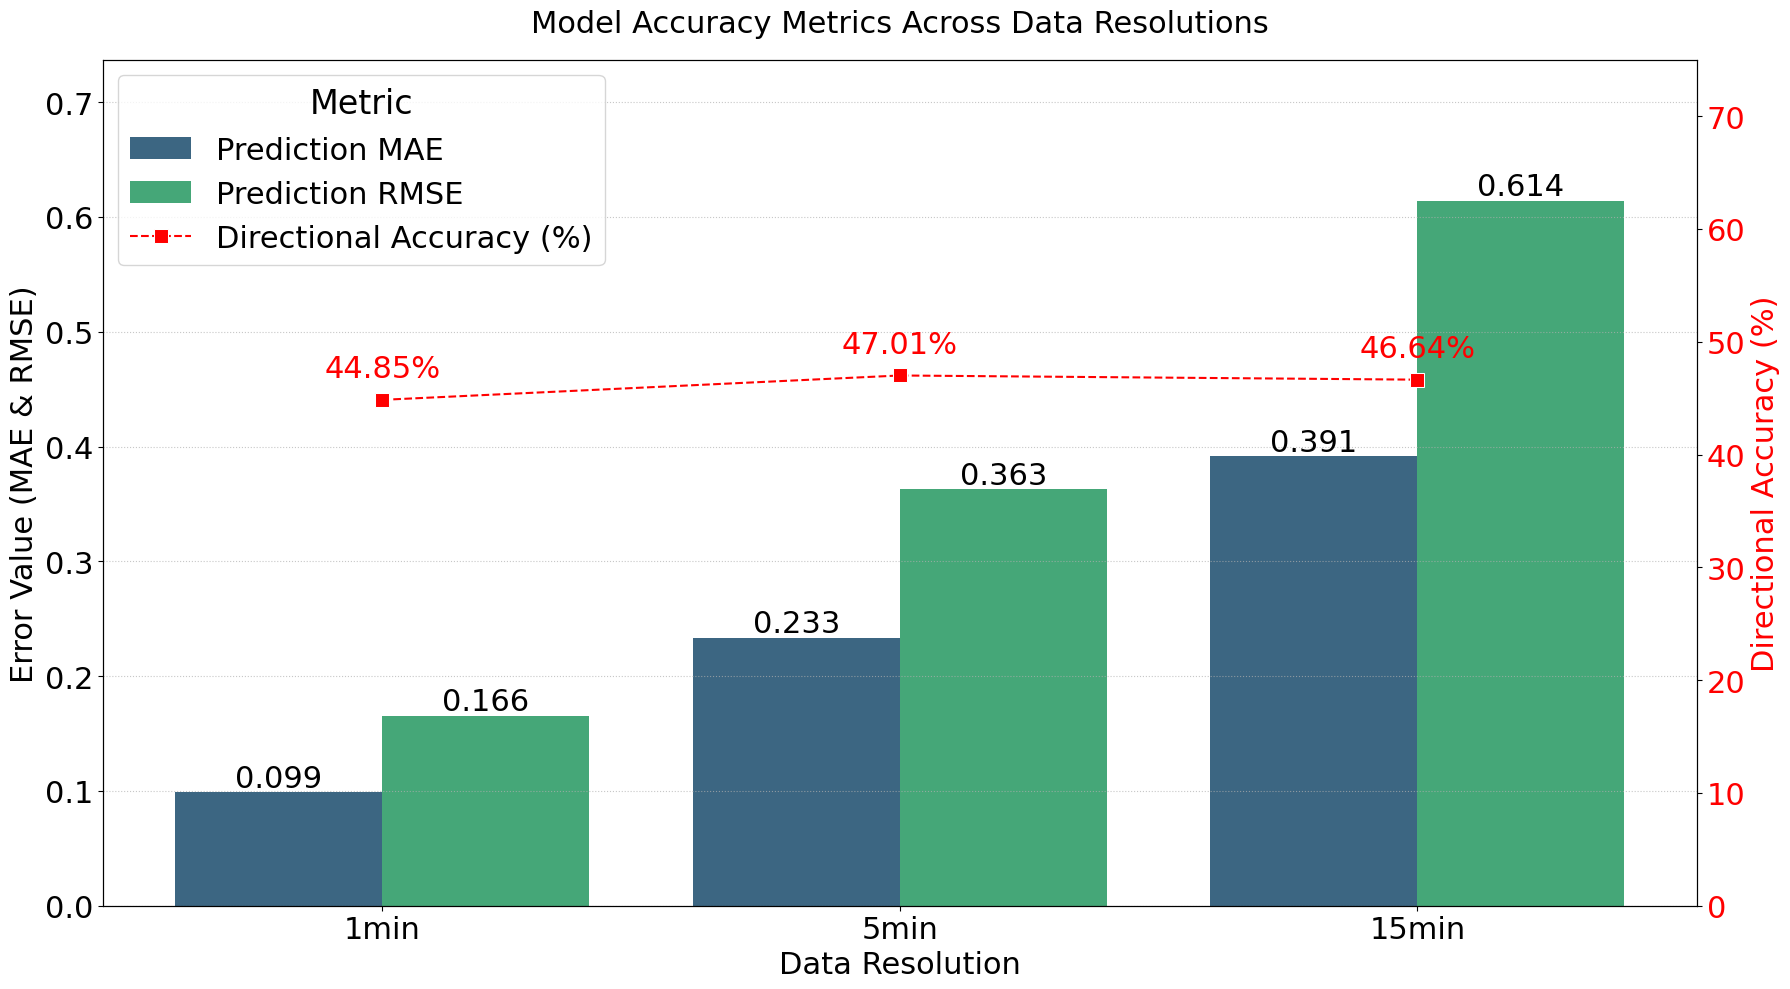

In [5]:
plot_3_axes_graph(PALETTE = 'viridis',
                  bars_coulmns = ['Prediction_Accuracy_MAE', 'Prediction_Accuracy_RMSE'],
                  X = 'Data_Resolution',
                  Y = 'Error Value (MAE & RMSE)',
                  Y2 = 'Prediction_Accuracy_Directional_Accuracy',
                  combined_legend_label='Directional Accuracy (%)',
                  color_='red',
                  title_ = 'Model Accuracy Metrics Across Data Resolutions',
                  y2_lim_ = (0, 75),
                  y1_metric_suffix="",
                  y2_metric_suffix="%",
                  plot_legend_loc='upper left',
                  rename_columns={"Prediction_Accuracy_MAE":"Prediction MAE","Prediction_Accuracy_RMSE":"Prediction RMSE"}
                 )

# LSTM Vs Passive Investment Across Data Resolutions Cumulative Return Comparison

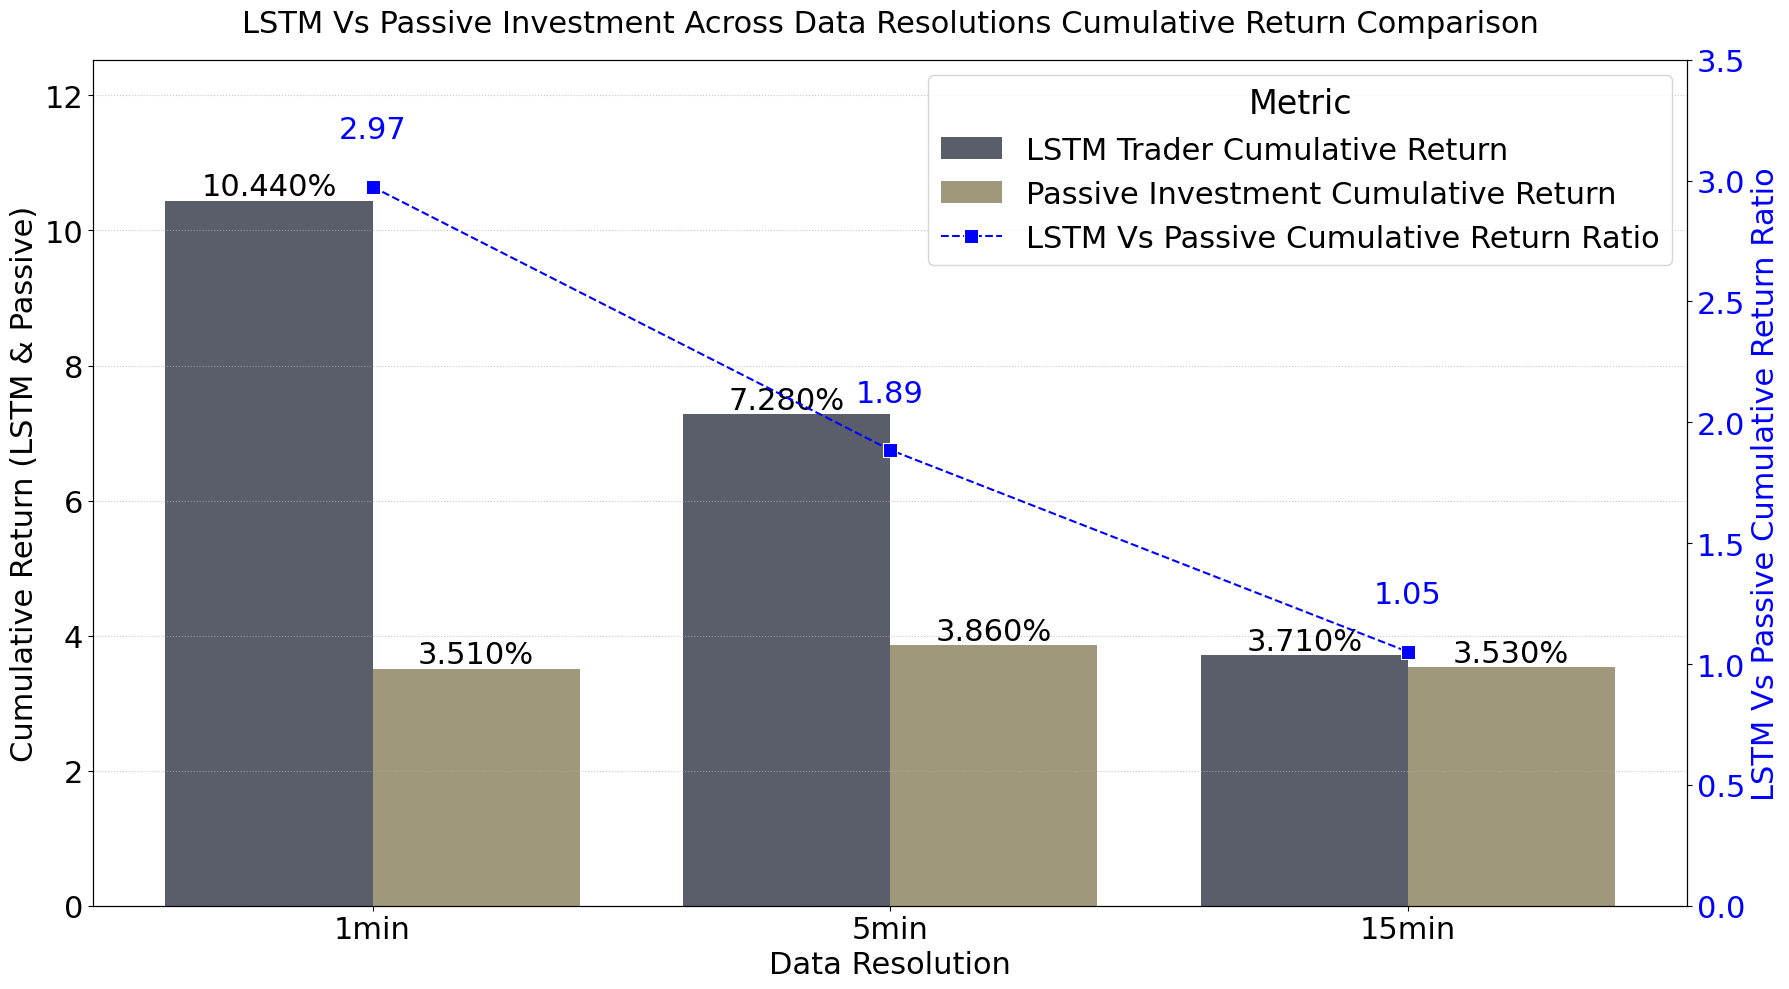

In [6]:
plot_3_axes_graph(PALETTE = 'cividis', #'viridis', 'plasma', 'inferno', 'magma', 'cividis'
                  bars_coulmns = ["Trading_Simulation_Cumulative_Return","Passive_Cumulative_Return"],
                  X = 'Data_Resolution',
                  Y = 'Cumulative Return (LSTM & Passive)',
                  Y2 = 'LSTM_Passive_Cumulative_Return_Ratio',
                  combined_legend_label='LSTM Vs Passive Cumulative Return Ratio',
                  color_='blue',
                  title_ = 'LSTM Vs Passive Investment Across Data Resolutions Cumulative Return Comparison',
                  y2_lim_ = (0, 3.5),
                  y1_metric_suffix="%",
                  y2_metric_suffix="",
                  plot_legend_loc='upper right',
                  rename_columns={"Trading_Simulation_Cumulative_Return":"LSTM Trader Cumulative Return","Passive_Cumulative_Return":"Passive Investment Cumulative Return"},
                  label_offset=0.2
                 )

# LSTM Vs Passive Investment Across Data Resolutions Sharpe Ratio (Annualized) Comparison

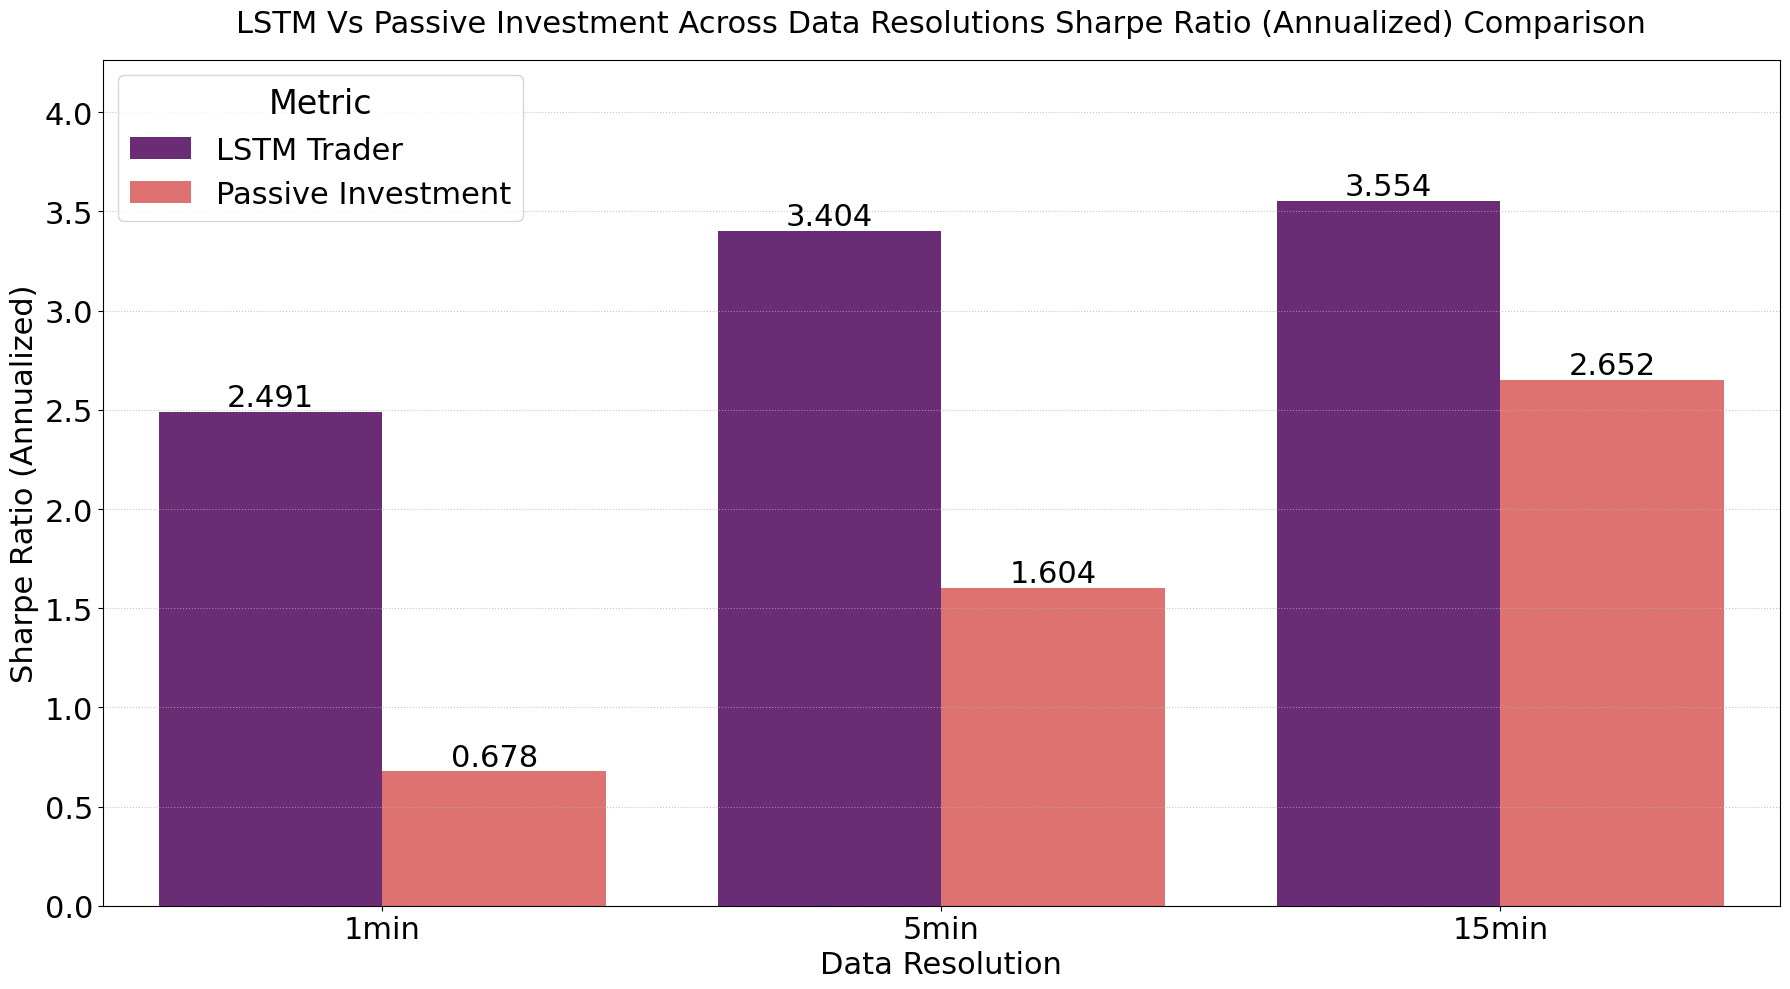

In [7]:
plot_3_axes_graph(PALETTE = 'magma', #'viridis', 'plasma', 'inferno', 'magma', 'cividis'
                  bars_coulmns = ["Trading_Simulation_Sharpe_Ratio_Annualized","Passive_Sharpe_Ratio_Annualized"],
                  X = 'Data_Resolution',
                  Y = 'Sharpe Ratio (Annualized)',
                  Y2 = None,
                  combined_legend_label='LSTM Vs Passive Cumulative Return Ratio',
                  color_='red',
                  title_ = 'LSTM Vs Passive Investment Across Data Resolutions Sharpe Ratio (Annualized) Comparison',
                  y2_lim_ = (0, 10),
                  y1_metric_suffix="",
                  y2_metric_suffix="",
                  plot_legend_loc='upper left',
                  rename_columns={"Trading_Simulation_Sharpe_Ratio_Annualized":"LSTM Trader","Passive_Sharpe_Ratio_Annualized":"Passive Investment"}
                 )               



# Computational Efficiency Comparison: Training Time vs. Inference Time

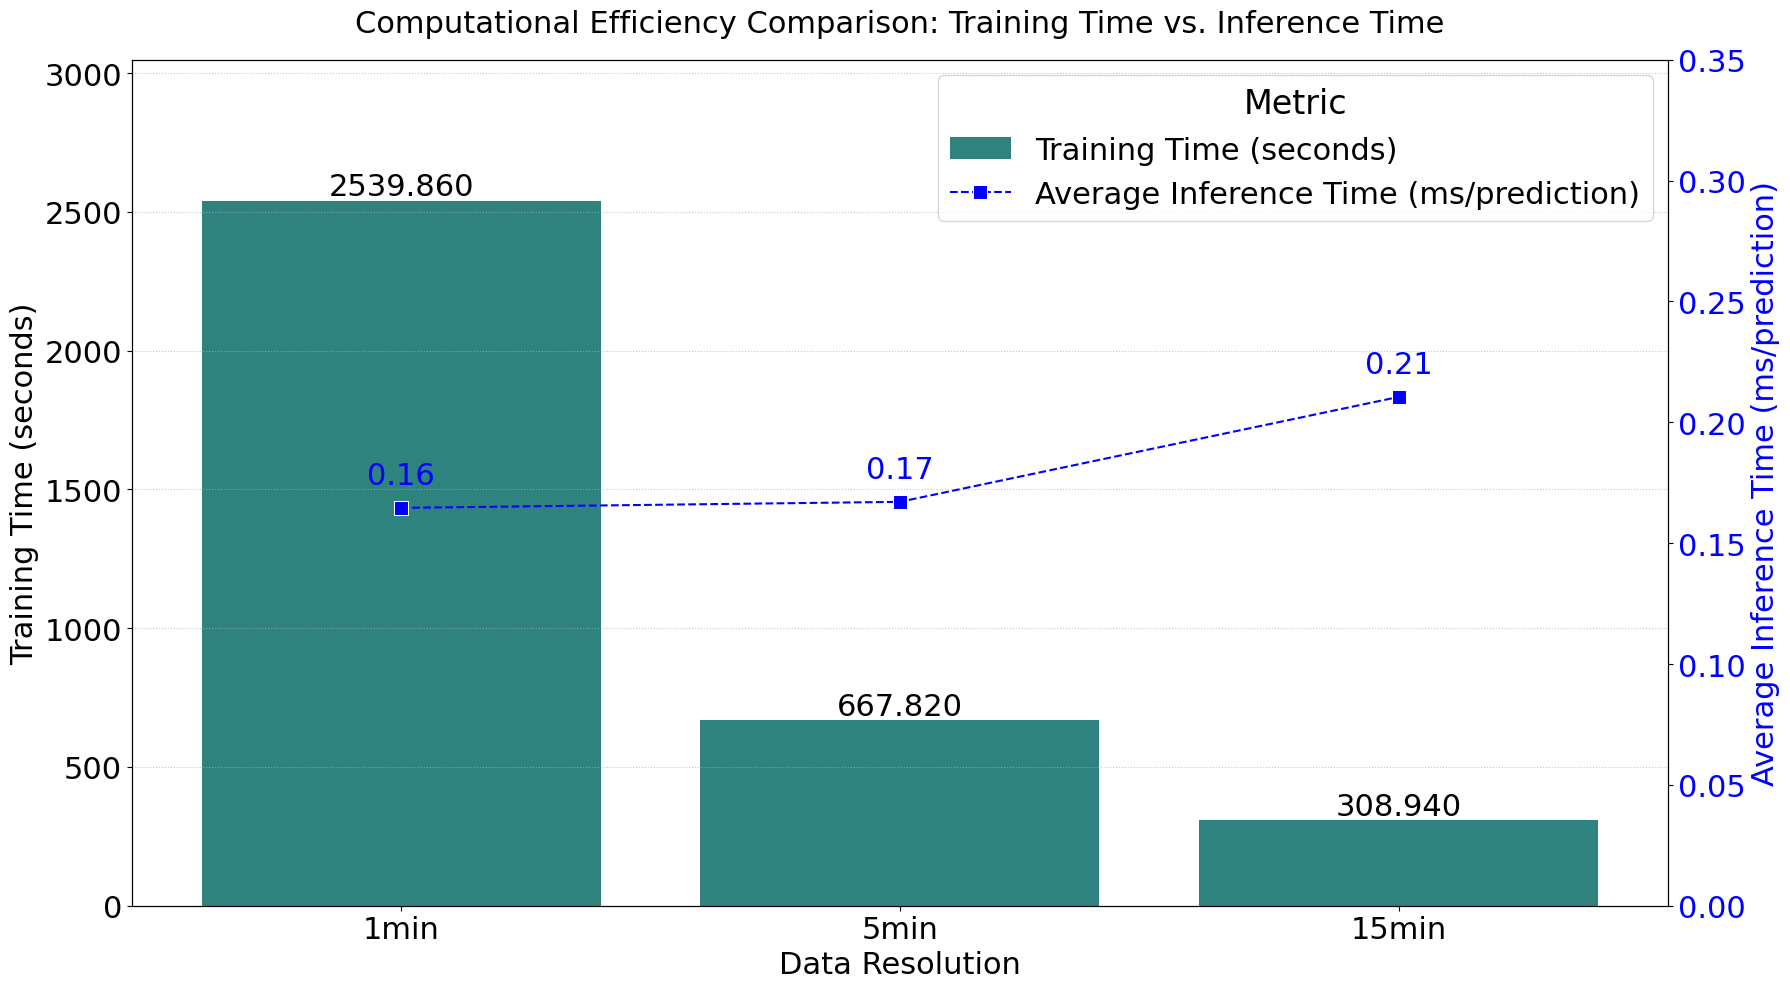

In [8]:
plot_3_axes_graph(PALETTE = 'viridis', #'viridis', 'plasma', 'inferno', 'magma', 'cividis'
                  bars_coulmns = ["Computational_Efficiency_Training_Time"],
                  X = 'Data_Resolution',
                  Y = 'Training Time (seconds)',
                  Y2 = 'Computational_Efficiency_Average_Inference_Time',
                  combined_legend_label='Average Inference Time (ms/prediction)',
                  color_='blue',
                  title_ = 'Computational Efficiency Comparison: Training Time vs. Inference Time',
                  y2_lim_ = (0, 0.35),
                  y1_metric_suffix="",
                  y2_metric_suffix="",
                  plot_legend_loc='upper right',
                  rename_columns={"Computational_Efficiency_Training_Time":"Training Time (seconds)"},
                  label_offset=0.01
                 )               
